In [224]:
# !pip install h3==3.7.6 --force-reinstall
# !pip install --upgrade shapely
# !pip install osmnx --upgrade
# !pip install shap
# !pip install lightgbm
# !pip install optuna

# !pip install yellowbrick

In [225]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3
import gzip
import shutil
import os
from shapely.geometry import Point
from shapely.geometry import Polygon
from h3 import geo_to_h3, h3_to_geo
import time
import logging
from datetime import datetime
import seaborn as sns
import matplotlib
matplotlib.rc('font', family='DejaVu Sans')
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
import optuna
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [226]:
H3_RESOLUTION = 8
TARGET_TYPE = 'Sewer: Blocked/Overflow'

In [227]:
#load the data

start_time = time.time()

file_name = "sr_hex.csv.gz"
var_name = "df_sr_hex"
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/"
url = base_url + file_name

print(f"Processing {file_name}...")
!wget -q {url}

# Unzip and load
csv_name = file_name[:-3]  
with gzip.open(file_name, 'rb') as f_in:
    with open(csv_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

os.remove(file_name)  

df = pd.read_csv(csv_name)

print(f"Loaded {file_name} in {time.time() - start_time:.2f} seconds")

Processing sr_hex.csv.gz...


Loaded sr_hex.csv.gz in 9.07 seconds


In [228]:
# Drop Records where h3_level8_index = '0' / is missing
print(df.shape)
df = df.loc[df.h3_level8_index != '0']
print(df.shape)

(941634, 16)
(729270, 16)


In [229]:
#Filter out records for TARGET_TYPE
df_type = df[df['code'] == TARGET_TYPE].groupby(['h3_level8_index'])['notification_number'].count().reset_index(name='num_requests')

In [230]:
df_type.head(2)

,h3_level8_index,num_requests
0,88ad360001fffff,21
1,88ad360003fffff,12


In [231]:
#Helper function
def h3_to_point(h3, resolution=8):
    return h3_to_geo(h3)

# Convert each h3_index to lat/lon
df_type[['latitude', 'longitude']] = df_type['h3_level8_index'].apply(lambda h: pd.Series(h3_to_point(h)))

In [232]:
df_type.head(2)

,h3_level8_index,num_requests,latitude,longitude
0,88ad360001fffff,21,-33.836215,18.494065
1,88ad360003fffff,12,-33.832471,18.485002


## Initial Solution - Baseline Model

In [233]:

X = df_type.drop(['num_requests'], axis=1)
X = X.set_index('h3_level8_index')
y = df_type['num_requests']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

#_train = np.log1p(y_train)
regressor = RandomForestRegressor(n_estimators = 50,oob_score = True)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
#y_pred = np.expm1(y_log_pred)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

Out-of-Bag Score: 0.29177969359489764
RMSE: 115.71275618824767
R2: 0.2935374270528077


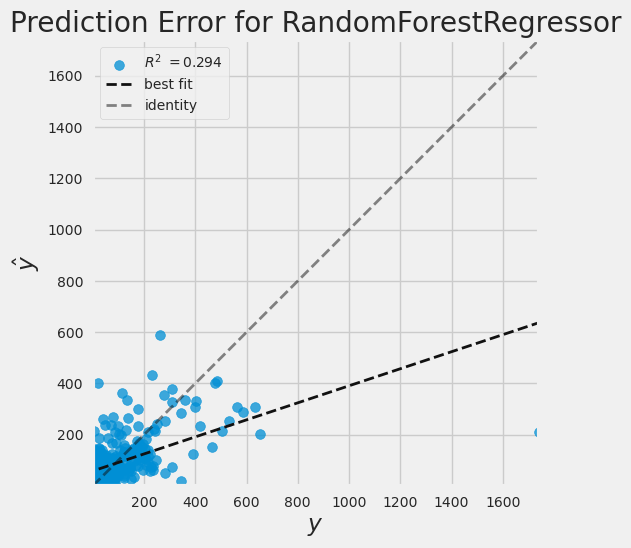

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [234]:
visualizer = PredictionError(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

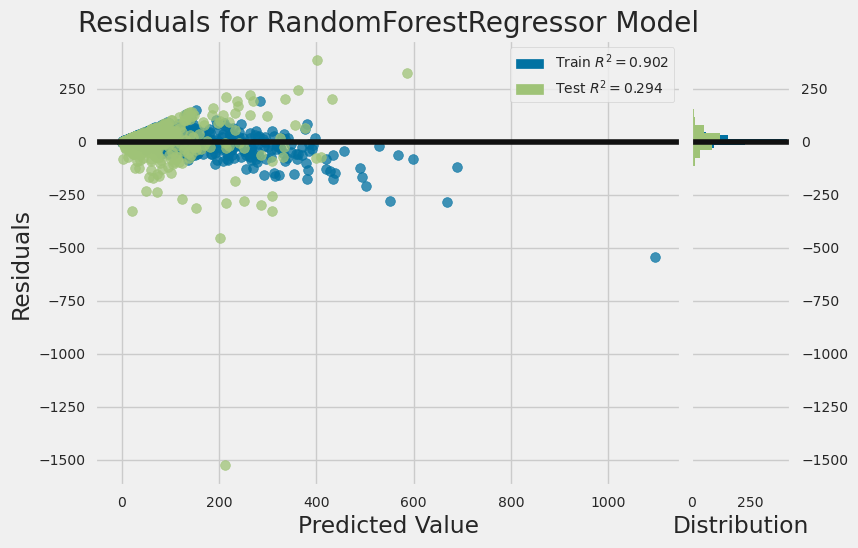

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [235]:
visualizer = ResidualsPlot(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

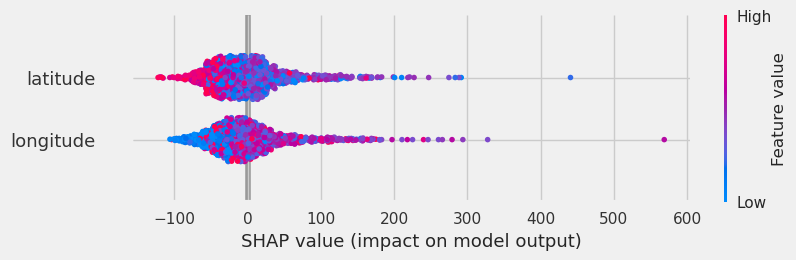

In [236]:
explainer = shap.Explainer(regressor)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values)

## Improved Solution
### Feature Engineering - Add External Data

In [237]:
# Features from OpenStreetMaps  (https://wiki.openstreetmap.org/wiki/Map_features)

# -------------------------------
# Settings
# -------------------------------
place_name = "City of Cape Town, Western Cape, South Africa"
resolution = 8

feature_tags = {
    "num_schools": {"amenity": "school"},
    "num_shops": {"shop": True},
    "num_bus_stops": {"highway": "bus_stop"},
    "num_clinics": {"amenity": "clinic"},
    "num_hospitals": {"amenity": "hospital"},
    "num_post_offices": {"amenity": "post_office"},
    "num_pharmacies": {"amenity": "pharmacy"},
    "num_banks": {"amenity": "bank"},
    "num_traffic_signals": {"highway": "traffic_signals"},
    "num_religious_sites": {"amenity": ["place_of_worship", "church", "mosque", "synagogue", "temple"]},
}

# -------------------------------
# Get Cape Town polygon using unary_union
# -------------------------------
print("Fetching Cape Town boundary...")
gdf_boundary = ox.geocode_to_gdf(place_name)
polygon = gdf_boundary.geometry.unary_union

# -------------------------------
# Helper functions
# -------------------------------
def point_to_h3(point, resolution=8):
    return h3.geo_to_h3(point.y, point.x, resolution)

def extract_and_aggregate(tag_label, tag_filter):
    print(f"Fetching {tag_label}...")
    try:
        time.sleep(2)
        gdf = ox.features_from_polygon(polygon, tags=tag_filter)
    except Exception as e:
        print(f"Failed to fetch {tag_label}: {e}")
        return pd.DataFrame(columns=["h3_level8_index", tag_label])

    gdf = gdf[gdf.geometry.notna()].copy()

    if gdf.geom_type.isin(['Polygon', 'MultiPolygon']).any():
        gdf['geometry'] = gdf['geometry'].centroid

    gdf = gdf[gdf.geometry.type == 'Point']
    gdf['h3_level8_index'] = gdf['geometry'].apply(lambda pt: point_to_h3(pt, resolution))

    agg = gdf.groupby('h3_level8_index').size().reset_index(name=tag_label)
    return agg

# -------------------------------
# Loop and Merge All Features
# -------------------------------
from functools import reduce

h3_feature_dfs = []

for label, tag in feature_tags.items():
    h3_df = extract_and_aggregate(label, tag)
    h3_feature_dfs.append(h3_df)

print("Merging all feature tables...")
df_h3_features = reduce(
    lambda left, right: pd.merge(left, right, on='h3_level8_index', how='outer'),
    h3_feature_dfs
)

df_h3_features.fillna(0, inplace=True)

# -------------------------------
# Final Output
# -------------------------------
print("Final H3 feature summary:")


Fetching Cape Town boundary...
Fetching num_schools...


Fetching num_shops...
Fetching num_bus_stops...
Fetching num_clinics...
Fetching num_hospitals...
Fetching num_post_offices...
Fetching num_pharmacies...
Fetching num_banks...
Fetching num_traffic_signals...
Fetching num_religious_sites...
Merging all feature tables...
Final H3 feature summary:


In [238]:
df_h3_features.head().T

,0,1,2,3,4
h3_level8_index,88ad360003fffff,88ad360005fffff,88ad360007fffff,88ad360021fffff,88ad360023fffff
num_schools,0.0,1.0,1.0,1.0,1.0
num_shops,0.0,1.0,1.0,0.0,2.0
num_bus_stops,0.0,0.0,0.0,4.0,5.0
num_clinics,0.0,0.0,0.0,0.0,0.0
num_hospitals,0.0,0.0,0.0,0.0,0.0
num_post_offices,0.0,0.0,0.0,0.0,0.0
num_pharmacies,0.0,0.0,1.0,0.0,0.0
num_banks,0.0,0.0,0.0,0.0,2.0
num_traffic_signals,5.0,4.0,11.0,1.0,0.0


In [239]:
#merge df_h3_features with df_type
print(df_type.shape)
df_type = pd.merge(df_type, df_h3_features, on='h3_level8_index', how='left')
df_type.fillna(0,inplace=True)
print(df_type.shape)
df_type.head()

(1501, 4)
(1501, 14)


,h3_level8_index,num_requests,latitude,longitude,num_schools,num_shops,num_bus_stops,num_clinics,num_hospitals,num_post_offices,num_pharmacies,num_banks,num_traffic_signals,num_religious_sites
0,88ad360001fffff,21,-33.836215,18.494065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,88ad360003fffff,12,-33.832471,18.485002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
2,88ad360005fffff,54,-33.832063,18.502176,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
3,88ad360007fffff,41,-33.828319,18.493112,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0
4,88ad36000dfffff,15,-33.839958,18.503130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
#Number of request types (excluding TARGET_TYPE)  per h3_level8_index

unique_types_per_hex = df[df.code != TARGET_TYPE].groupby('h3_level8_index')['code'].nunique().reset_index()
unique_types_per_hex.columns = ['h3_level8_index', 'num_unique_request_types']

# Preview result
unique_types_per_hex.sort_values('num_unique_request_types', ascending=False).head()

,h3_level8_index,num_unique_request_types
685,88ad361519fffff,185
716,88ad3615c1fffff,164
698,88ad361547fffff,164
697,88ad361545fffff,161
123,88ad36024bfffff,155


In [241]:
#merge unique_types_per_hex with df_type
print(df_type.shape)
df_type = pd.merge(df_type, unique_types_per_hex, on='h3_level8_index', how='left')
df_type.fillna(0,inplace=True)
print(df_type.shape)

(1501, 14)
(1501, 15)


In [242]:
#dominant request type per h3_level8_index excluding TARGET_TYPE

dominant_counts = (
    df[df.code != TARGET_TYPE].groupby(['h3_level8_index', 'code']).size()
    .reset_index(name='count')
    .sort_values(['h3_level8_index', 'count'], ascending=[True, False])
    .drop_duplicates('h3_level8_index')
    .rename(columns={'code': 'dominant_request_type', 'count': 'dominant_type_count'})
)

#merge dominant_counts with df_type
print(df_type.shape)
df_type = pd.merge(df_type, dominant_counts, on='h3_level8_index', how='left')
df_type['dominant_request_type'] = df_type['dominant_request_type'].fillna('Unknown')
df_type['dominant_type_count'] = df_type['dominant_type_count'].fillna(0).astype(int)
print(df_type.shape)

(1501, 15)
(1501, 17)


In [243]:
# #Interaction features
# def create_interaction_features(df):
#     # Avoid divide-by-zero by adding 1 in denominators
#     def safe_divide(numerator, denominator):
#         return numerator / (denominator + 1)

#     # 📘 Relative Access Indicators
#     df['schools_per_bus_stop'] = safe_divide(df['num_schools'], df['num_bus_stops'])
#     df['clinics_per_pharmacy'] = safe_divide(df['num_clinics'], df['num_pharmacies'])
#     df['shops_per_school'] = safe_divide(df['num_shops'], df['num_schools'])
#     df['religious_sites_per_resident_service'] = safe_divide(
#         df['num_religious_sites'], df['num_clinics'] + df['num_schools']
#     )

#     # 📘 Infrastructure Burden Indicators
#     df['requests_per_school'] = safe_divide(df['num_unique_request_types'], df['num_schools'])
#     df['requests_per_bus_stop'] = safe_divide(df['num_unique_request_types'], df['num_bus_stops'])
#     df['requests_per_health_site'] = safe_divide(
#         df['num_unique_request_types'], df['num_clinics'] + df['num_hospitals']
#     )

#     # 📘 Supply-Demand Balances
#     df['dominant_count_per_school'] = safe_divide(df['dominant_type_count'], df['num_schools'])
#     df['dominant_count_per_shop'] = safe_divide(df['dominant_type_count'], df['num_shops'])
#     df['dominant_count_per_service_point'] = safe_divide(
#         df['dominant_type_count'], df['num_clinics'] + df['num_bus_stops']
#     )

#     # 📘 Location-Based Interaction Terms
#     df['lat_lon_product'] = df['latitude'] * df['longitude']
#     df['lat_squared'] = df['latitude'] ** 2
#     df['lon_squared'] = df['longitude'] ** 2
#     df['lat_times_request_types'] = df['latitude'] * df['num_unique_request_types']

#     # 📘 Co-location & Saturation
#     service_cols = ['num_schools', 'num_clinics', 'num_pharmacies', 'num_banks', 'num_shops', 'num_bus_stops']
#     df['num_services'] = (df[service_cols] > 0).sum(axis=1)
#     df['services_ratio'] = df['num_services'] / len(service_cols)

#     return df

# df_type = create_interaction_features(df_type)

In [244]:
df_type.head().T

,0,1,2,3,4
h3_level8_index,88ad360001fffff,88ad360003fffff,88ad360005fffff,88ad360007fffff,88ad36000dfffff
num_requests,21,12,54,41,15
latitude,-33.836215,-33.832471,-33.832063,-33.828319,-33.839958
longitude,18.494065,18.485002,18.502176,18.493112,18.50313
num_schools,0.0,0.0,1.0,1.0,0.0
num_shops,0.0,0.0,1.0,1.0,0.0
num_bus_stops,0.0,0.0,0.0,0.0,0.0
num_clinics,0.0,0.0,0.0,0.0,0.0
num_hospitals,0.0,0.0,0.0,0.0,0.0
num_post_offices,0.0,0.0,0.0,0.0,0.0


In [245]:
# Train the model

X = df_type.drop(columns = ["num_requests"], axis = 1)
X = X.set_index("h3_level8_index")
y = df_type["num_requests"]

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

numeric_features = selector(dtype_include='number')(X_train)
categorical_features = selector(dtype_include='object')(X_train)

#Ensure categorical columns are all string type
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
('regressor', LGBMRegressor(random_state=42))
])  #LGBMRegressor(random_state=42)  RandomForestRegressor(random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

RMSE: 105.959589492705
R2: 0.4076106852143727


### Hyperparameter Tuning

In [246]:
def objective(trial):
    # LightGBM hyperparameters
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
        "verbosity": -1,
    }

    # Split numeric and categorical features
    num_cols = X.select_dtypes(include="number").columns.tolist()
    cat_cols = X.select_dtypes(include="object").columns.tolist()

    # Preprocessing pipeline
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ])

    # Final model pipeline
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", LGBMRegressor(**params))
    ])

    # 5-fold CV with RMSE scoring
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error")

    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2025-07-06 15:01:24,703] A new study created in memory with name: no-name-0509a611-14f4-4813-85f9-303680a40815
[I 2025-07-06 15:01:26,103] Trial 0 finished with value: 89.00090065836284 and parameters: {'learning_rate': 0.04477108934764101, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 42, 'min_data_in_leaf': 79, 'subsample': 0.7877219562393869, 'colsample_bytree': 0.7234960222515849, 'reg_alpha': 0.09423600725468298, 'reg_lambda': 0.7919406774094476}. Best is trial 0 with value: 89.00090065836284.
[I 2025-07-06 15:01:27,162] Trial 1 finished with value: 86.56846718311559 and parameters: {'learning_rate': 0.010605571869029296, 'num_leaves': 72, 'max_depth': 3, 'min_child_samples': 72, 'min_data_in_leaf': 60, 'subsample': 0.6406718658501396, 'colsample_bytree': 0.9615684808807725, 'reg_alpha': 0.06710375973892192, 'reg_lambda': 9.963647848441695}. Best is trial 1 with value: 86.56846718311559.
[I 2025-07-06 15:01:28,282] Trial 2 finished with value: 87.56805708826758 and p

Best hyperparameters: {'learning_rate': 0.00935555601543204, 'num_leaves': 147, 'max_depth': 14, 'min_child_samples': 95, 'min_data_in_leaf': 38, 'subsample': 0.6885225557625899, 'colsample_bytree': 0.5289995063350378, 'reg_alpha': 0.2327949683750698, 'reg_lambda': 0.004626536132194807}
Best RMSE: 84.36738932388286


In [247]:
params = study.best_params

numeric_features = selector(dtype_include='number')(X_train)
categorical_features = selector(dtype_include='object')(X_train)

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(**params,
                                objective= "regression",
                                metric="rmse",
                                n_estimators=1000,
                                verbosity= -1,
                                bagging_freq= 1,))
                            ])  

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))


RMSE: 101.45699673893392
R2: 0.4568863886066139


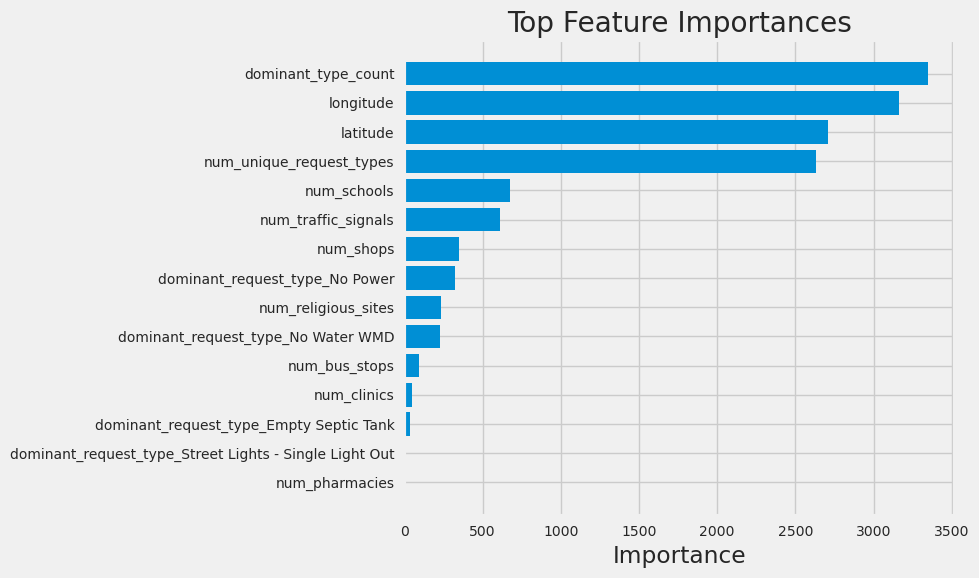

In [248]:
#Feature Importance

model = pipeline.named_steps['regressor']

# Feature Names
num_features = numeric_features
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_features, cat_feature_names])

# Imporances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N
N = 15
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.barh(range(N), importances[indices[:N]][::-1])
plt.yticks(range(N), feature_names[indices[:N]][::-1])
plt.xlabel("Importance")
plt.tight_layout()
# plt.gca().invert_yaxis()
plt.show()

### Use the final model to predict the full dataset

In [249]:
params = study.best_params

numeric_features = selector(dtype_include='number')(X)
categorical_features = selector(dtype_include='object')(X)

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(**params,
                                objective= "regression",
                                metric="rmse",
                                n_estimators=1000,
                                verbosity= -1,
                                bagging_freq= 1,))
                            ])  

pipeline.fit(X, y)
y_pred = pipeline.predict(X)

print("RMSE:", mean_squared_error(y, y_pred, squared=False))
print("R2:", r2_score(y, y_pred))

RMSE: 69.45044455340162
R2: 0.7090383781071984


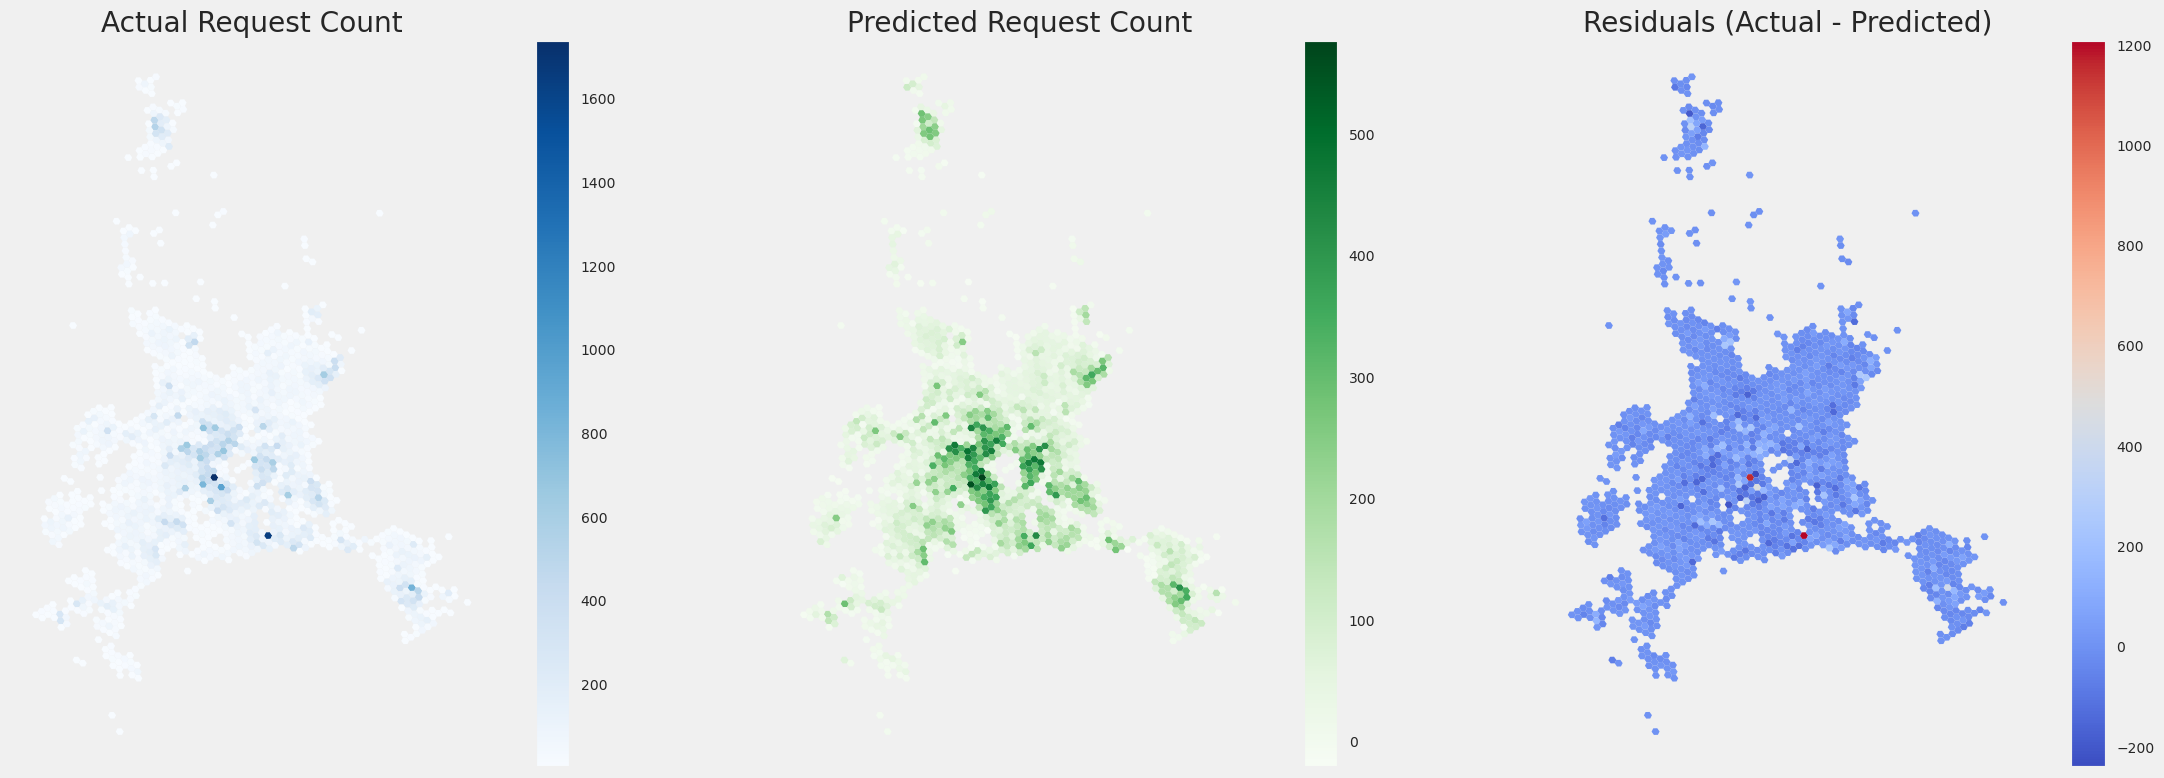

In [250]:
results_df = X.copy()
results_df = results_df.reset_index()
results_df['actual'] = y
results_df['predicted'] = y_pred
results_df['residual'] = results_df['actual'] - results_df['predicted']
results_df['h3_index'] = results_df['h3_level8_index']

# 3. Convert h3 index to polygon
def h3_to_geo_boundary(h):
    boundary = h3.h3_to_geo_boundary(h, geo_json=True)
    return Polygon(boundary)

results_df = results_df[results_df['h3_index'].notna()].copy()
results_df['geometry'] = results_df['h3_index'].apply(h3_to_geo_boundary)
gdf = gpd.GeoDataFrame(results_df, geometry='geometry', crs='EPSG:4326')

# 4. Plot actual vs predicted vs residuals
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Actual
gdf.plot(column='actual', cmap='Blues', legend=True, ax=axes[0])
axes[0].set_title("Actual Request Count")

# Predicted
gdf.plot(column='predicted', cmap='Greens', legend=True, ax=axes[1])
axes[1].set_title("Predicted Request Count")

# Residuals
gdf.plot(column='residual', cmap='coolwarm', legend=True, ax=axes[2])
axes[2].set_title("Residuals (Actual - Predicted)")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()